# Experiments with the greedy policy

In [22]:
from utils.card_engine import Card_Game, Card_Env, greedy_policy, move_to_card, get_legal_moves

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import random

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [37]:
def plot_durations_rewards(durations, rewards, show_result=False):
    fig, ax = plt.subplots(2, 1)

    durations_t = torch.tensor(durations, dtype=torch.float)
    rewards_t = torch.tensor(rewards, dtype=torch.float)

    title = 'Result' if show_result else 'Training...'
    ax[0].set_title(f'{title} Duations each Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Duration')

    ax[1].set_title(f'{title} Rewards each Episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')

    ax[0].plot(durations_t.numpy())
    ax[1].plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0].plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[1].plot(means.numpy())

    fig.tight_layout()

    # plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     if not show_result:
    #         display.clear_output(wait=True)
    #         display.display(fig)
    #     else:
    #         display.display(fig)


'''
simulate a game using policy against random agents
input:
- policy: game -> move
returns moves_played, culmulative_reward
'''
def simulate_game_random(policy, verbose=False, from_move=0):
    moves_played = 0
    culmulative_reward = 0

    active_player = from_move % 4
    if verbose:
        print(f"Starting new game as player {active_player} from turn {from_move}.")

    env = Card_Env()

    while env.game.current_player != active_player:
        move = env.game.sample_legal_move()
        env.game.play_card(move)

    for turn in range(13):
        move = policy(env.game)
        if not(move in env.game.get_legal_moves()):
            if verbose:
                print(f"Tried to play illegal move {move_to_card(move)}")
            return moves_played, culmulative_reward
        
        if verbose:
            print(f"Player plays {move_to_card(move)}")
        
        _, reward, terminated = env.step(move, None)

        moves_played += 1
        culmulative_reward += reward

        if terminated:
            return moves_played, culmulative_reward
    
    return moves_played, culmulative_reward


def simulate(policy, num_games, verbose=False):
    durations = []
    rewards = []

    simul_dist = [0 for _ in range(14)]

    for _ in range(num_games):
        moves_played, culmulative_reward = simulate_game_random(policy, verbose, from_move=random.randint(0,3))
        durations.append(moves_played)
        rewards.append(culmulative_reward)
        simul_dist[moves_played] += 1

    plot_durations_rewards(durations, rewards, show_result=True)
    print(f'Simulated {num_games} games.')
    print(f'Average simulated game duration: {sum(durations) / num_games}')
    print(f'Average reward per game: {sum(rewards) / num_games}')
    print(f"Distribution of simulated game lengths: {simul_dist}")


## Simulate games using the greedy policy

Average simulated game duration: 13.0
Average reward per game: 3.8
Distribution of simulated game lengths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]


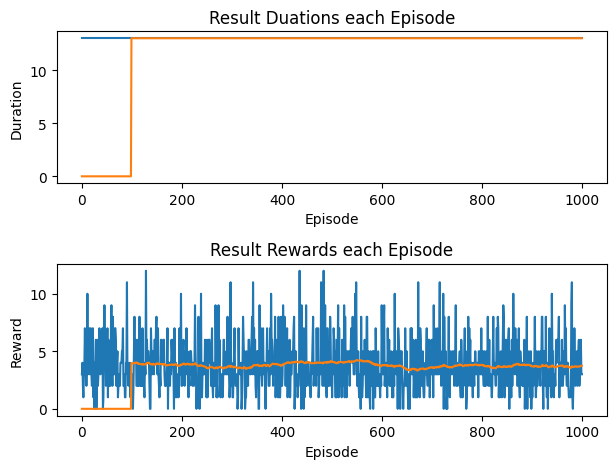

In [16]:
simulate(greedy_policy, 1000)

# Simulate games using trained networks

In [20]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [19]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand      ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        # print(f'x.shape = {x.shape}')
        # legal_moves_mask = get_legal_moves(x)
        # legal_moves_mask = x[-52:]
        # print(f'legal_moves_mask.map_location=torch.device('cpu')shape = {legal_moves_mask.shape}')
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        # return 13* torch.tanh(self.layer3(x))
        # print(f'output.shape = {self.layer3(x).shape}')
        return self.layer3(x)

In [21]:
env = Card_Env()
state = env.game.get_network_input()
n_input = len(state)
n_output = 52

trained_network = DQN(n_input, n_output).to(device)

In [33]:
# trained_network.load_state_dict(torch.load('weights/'))

def policy_legal_move(net, input):
    legal_mask = get_legal_moves(input).to(device)
    x = (net(input.to(device))) * legal_mask
    x[x == 0] = -float('inf')
    return x.max(0).indices.view(1,1)

def policy_agent(net, game):
    with torch.no_grad():
        return policy_legal_move(net, game.get_network_input()).item()

def simulate_with_network(weights, num_games, verbose=False):
    trained_network = DQN(n_input, n_output).to(device)
    if device == torch.device('cpu'):
        trained_network.load_state_dict(torch.load(weights, map_location=torch.device('cpu'))weights/))
    else:
        trained_network.load_state_dict(torch.load(weights))

    trained_policy = lambda game : policy_agent(trained_network, game)

    simulate(trained_policy, num_games, verbose)

Average simulated game duration: 13.0
Average reward per game: 3.666
Distribution of simulated game lengths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]


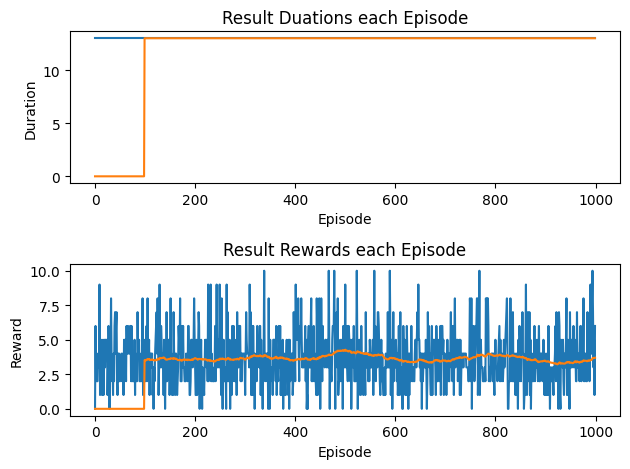

In [35]:
simulate_with_network('weights/q_fn_816-100000.pth', 1000)

/home/txmszlou/Work/erdos-workshop/deep-learning/dqn-trick-game/utils/card_engine.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()


Average simulated game duration: 13.0
Average reward per game: 3.673
Distribution of simulated game lengths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]


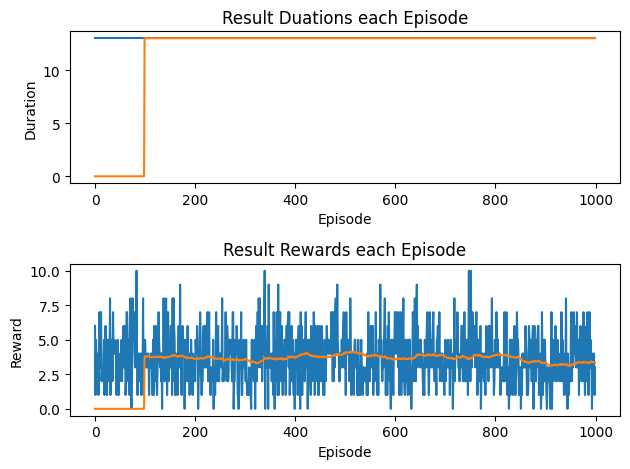

In [36]:
simulate_with_network('weights/ev_q_function_output.pth', 1000)